## Importing libraries

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.applications.xception import preprocess_input
import cv2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers
from PIL import Image, ImageOps

## Reading data

In [2]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    c = 0
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    image_files.sort()  # opcjonalnie

    if not image_files:
        raise ValueError("Brak plików .jpg w podanym katalogu!")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Wczytaj i przeskaluj obraz do dokładnego rozmiaru target_size (bez paddingu)
        img = Image.open(img_path).convert('RGB')
        img_resized = img.resize(target_size, Image.LANCZOS)

        # Konwersja do numpy + preprocess_input (dla MobileNet)
        img_array = np.array(img_resized, dtype=np.float32)
        img_array = preprocess_input(img_array)

        # Wczytaj ground truth (liczba osób)
        mat = scipy.io.loadmat(mat_path)
        count = len(mat['image_info'][0][0][0][0][0])

        X.append(img_array)
        y.append(count)
        # if c == 1:
        #     plt.imshow(img_resized)
        #     print(img_path)
        #     print(count)
        #     break
        # c += 1

    return np.array(X), np.array(y)

## Getting the training set and the test set

In [3]:
X_train, y_train = load_dataset('ShanghaiTech/part_B/train_data/images/', 'ShanghaiTech/part_B/train_data/ground-truth/')

In [4]:
X_test, y_test = load_dataset('ShanghaiTech/part_B/test_data/images/', 'ShanghaiTech/part_B/test_data/ground-truth/')

## Building the model

In [6]:
# Load pre-trained model without top classifier layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

base_model.trainable = True
for layer in base_model.layers[:-3]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])

model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

## Data augmentation and training the model

In [7]:
# Function to augment
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x), y

training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_set = training_set.map(augment)  # augment
training_set = training_set.batch(32).prefetch(tf.data.AUTOTUNE)
history = model.fit(training_set, batch_size=32,
    epochs=20, shuffle=True, validation_data=(X_test, y_test)
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step - loss: 23870.6699 - mae: 122.0795 - val_loss: 15501.3545 - val_mae: 83.9138
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - loss: 17073.5742 - mae: 93.9806 - val_loss: 9677.3975 - val_mae: 69.8637
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - loss: 12489.7354 - mae: 77.9647 - val_loss: 9918.2246 - val_mae: 80.4446
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - loss: 9291.2051 - mae: 69.8488 - val_loss: 10847.9961 - val_mae: 87.7389
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - loss: 8287.3789 - mae: 66.3811 - val_loss: 8782.7686 - val_mae: 76.8408
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - loss: 7075.7065 - mae: 61.0423 - val_loss: 7271.0698 - val_mae: 67.1328
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - loss: 6704.3423 - mae: 58.8369 - val_loss: 6503.3032 - val_mae: 61.7351
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - loss: 5856.6396 - mae: 54.9451 - val_loss: 5970.5405 - val_mae: 57.9556
Ep

## Training curves visualisation

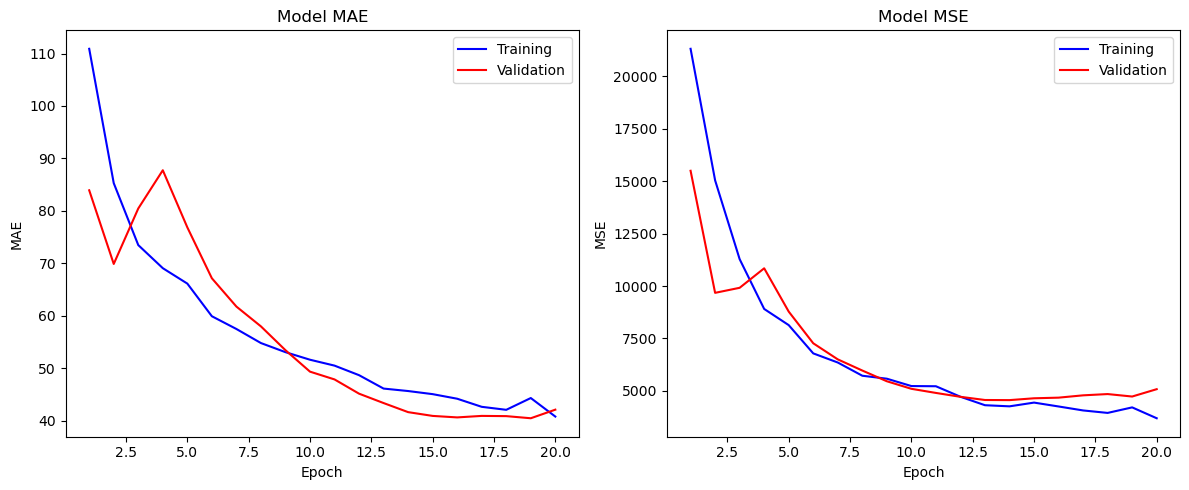

In [8]:
history_dict = history.history

# Getting the metrics
mae = history_dict['mae']
val_mae = history_dict.get('val_mae')
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')

epochs = range(1, len(mae) + 1)

# MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b-', label='Training')
if val_mae:
    plt.plot(epochs, val_mae, 'r-', label='Validation')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

## Making predictions

In [9]:
y_pred = np.round(model.predict(X_test))

10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step


In [10]:
y_pred.reshape(len(y_pred), 1)
y_test.reshape(len(y_test), 1)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[ 14.  23.]
 [132. 181.]
 [151. 157.]
 [ 40.  37.]
 [127.  70.]
 [ 52.  57.]
 [ 50.  44.]
 [184. 227.]
 [128. 165.]
 [184. 476.]
 [114. 139.]
 [160. 316.]
 [161. 164.]
 [ 96. 110.]
 [ 27.  20.]
 [147. 131.]
 [ 27.  48.]
 [133. 183.]
 [117. 101.]
 [229. 204.]
 [ 64.  40.]
 [ 65. 143.]
 [135. 146.]
 [150. 513.]
 [ 83.  70.]
 [110. 175.]
 [ 57.  51.]
 [ 50.  55.]
 [ 98.  67.]
 [ 96.  72.]
 [ 70.  56.]
 [131. 165.]
 [ 22.  32.]
 [ 79. 149.]
 [ 59.  48.]
 [ 61.  80.]
 [ 68. 117.]
 [ 62. 162.]
 [121. 137.]
 [112. 120.]
 [125.  72.]
 [130. 122.]
 [ 87. 198.]
 [ 70. 133.]
 [127. 147.]
 [ 47.  29.]
 [ 30.  70.]
 [ 43.  35.]
 [ 46.  24.]
 [156. 251.]
 [ 54.  59.]
 [ 91.  67.]
 [ 64.  61.]
 [159. 248.]
 [211. 252.]
 [147. 147.]
 [ 29.  57.]
 [108. 121.]
 [ 12.  47.]
 [241. 505.]
 [202. 297.]
 [229. 465.]
 [124. 167.]
 [ 56.  43.]
 [ 45.  46.]
 [ 86.  91.]
 [141. 263.]
 [ 94.  92.]
 [ 94. 117.]
 [ 39.  48.]
 [ 53.  54.]
 [ 84.  73.]
 [ 99. 122.]
 [ 88.  60.]
 [171. 170.]
 [ 78. 167.]
 [ 29.  57.]

## Metrics

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
print("R2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

R2: 0.43842053413391113
MSE: 5082.37646484375
MAE: 42.072784423828125
RMSE: 71.29078674316406
